# Visualizing MaxStyle generated images 

In [47]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot  as plt
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES']="0"

import sys
sys.path.append('/vol/biomedic3/cc215/Project/MaxStyle')
from src.common_utils.basic_operations import load_img_label_from_path,crop_or_pad,rescale_intensity
from src.models.model_util import makeVariable
from src.models.advanced_triplet_recon_segmentation_model import AdvancedTripletReconSegmentationModel
from src.common_utils.vis import plot_image,plot_general

torch.cuda.empty_cache()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Load data


load a batch of image slices:  (20, 192, 192) (20, 192, 192)


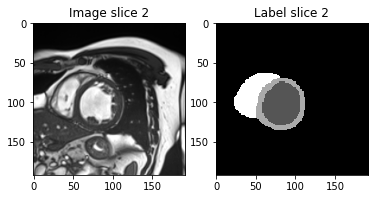

In [48]:
## cardiac setting 
image = np.load('./data/image.npy')
label = np.load('./data/label.npy')
print ('load a batch of image slices: ',image.shape,label.shape)
slice_id = 2
plt.subplot(121)
plt.title(f'Image slice {slice_id}')
plt.imshow(image[slice_id],cmap='gray')
plt.subplot(122)
plt.title(f'Label slice {slice_id}')
plt.imshow(label[slice_id],cmap='gray',interpolation='nearest')


# 2. Load saved models

In [49]:
## here we load the model trained w/ standard training
checkpoint_dir = './model'
network_type = 'FCN_16_standard_no_STN'
num_classes = 4
segmentation_model = AdvancedTripletReconSegmentationModel(network_type = network_type,
                                                          checkpoint_dir=checkpoint_dir,
                                                          num_classes=num_classes,use_gpu=True,debug=False)


segmentation_model.eval()

construct FCN_16_standard_no_STN
initialize model
load saved params from ./model/image_encoder.pth
load saved params from ./model/segmentation_decoder.pth
load saved params from ./model/image_decoder.pth
initialize model end
convert to cuda model
convert to cuda model end
set optimizer Adam for: image_encoder
set optimizer Adam for: segmentation_decoder
set optimizer Adam for: image_decoder
No schedulers for optimizers


# 3. Extract latent image content code z_i and shape code z_s

In [50]:
torch.cuda.empty_cache()
imageV = makeVariable(torch.from_numpy(image[:,np.newaxis,:,:]),type='float',requires_grad=False,use_gpu=True)
labelV = makeVariable(torch.from_numpy(label),type='long',requires_grad=False,use_gpu=True)
imageV = rescale_intensity(imageV)
segmentation_model.eval()
(z_i,z_s), initial_predict = segmentation_model.fast_predict(imageV)

# 4. Insert MaxStyle layers at different locations and perform adversarial optimization with different number of iterations

In [51]:

## insert maxstyle at different layers for style augmentation
methods = {
    '1':[1],
    '2':[2],
    '3': [3],
    '4': [4],
    '5': [5],
    '34':[3,4],
    '35':[3,5],
    '45':[4,5],
    '345':[3,4,5], # in practice, we use this one as a trade-off between style diveristy and computation efficiency
    '2345':[2,3,4,5],
    '12345':[1,2,3,4,5]
}
n_iter_list = [0,1,3,5,7]
results = {}
for i,(method,method_value) in enumerate(methods.items()):
    results[method] ={}
    fix_seed=i*40+7
    for j,n_iter in enumerate(n_iter_list):
        ## fix seed for ease of comparison between results with different n_iter
        recon_image = segmentation_model.generate_max_style_image(image_code=z_i, decoder_layers_indexes=method_value, channel_num=[128, 64, 32, 16, 16,1],
                                              p=0.5,
                                              n_iter=n_iter, mix_style=True, lr=0.1, no_noise=False,
                                              reference_image=imageV, reference_segmentation=labelV,
                                              noise_learnable=True,
                                              mix_learnable=True,
                                              loss_types=['seg'],
                                              loss_weights=[1],
                                              always_use_beta=True,debug=False,fix_seed=fix_seed)
        prediction = segmentation_model.predict(recon_image.detach())
        results[method][n_iter] = [recon_image,prediction]



# 5. Visualization: Generated images and corresponding network predictions

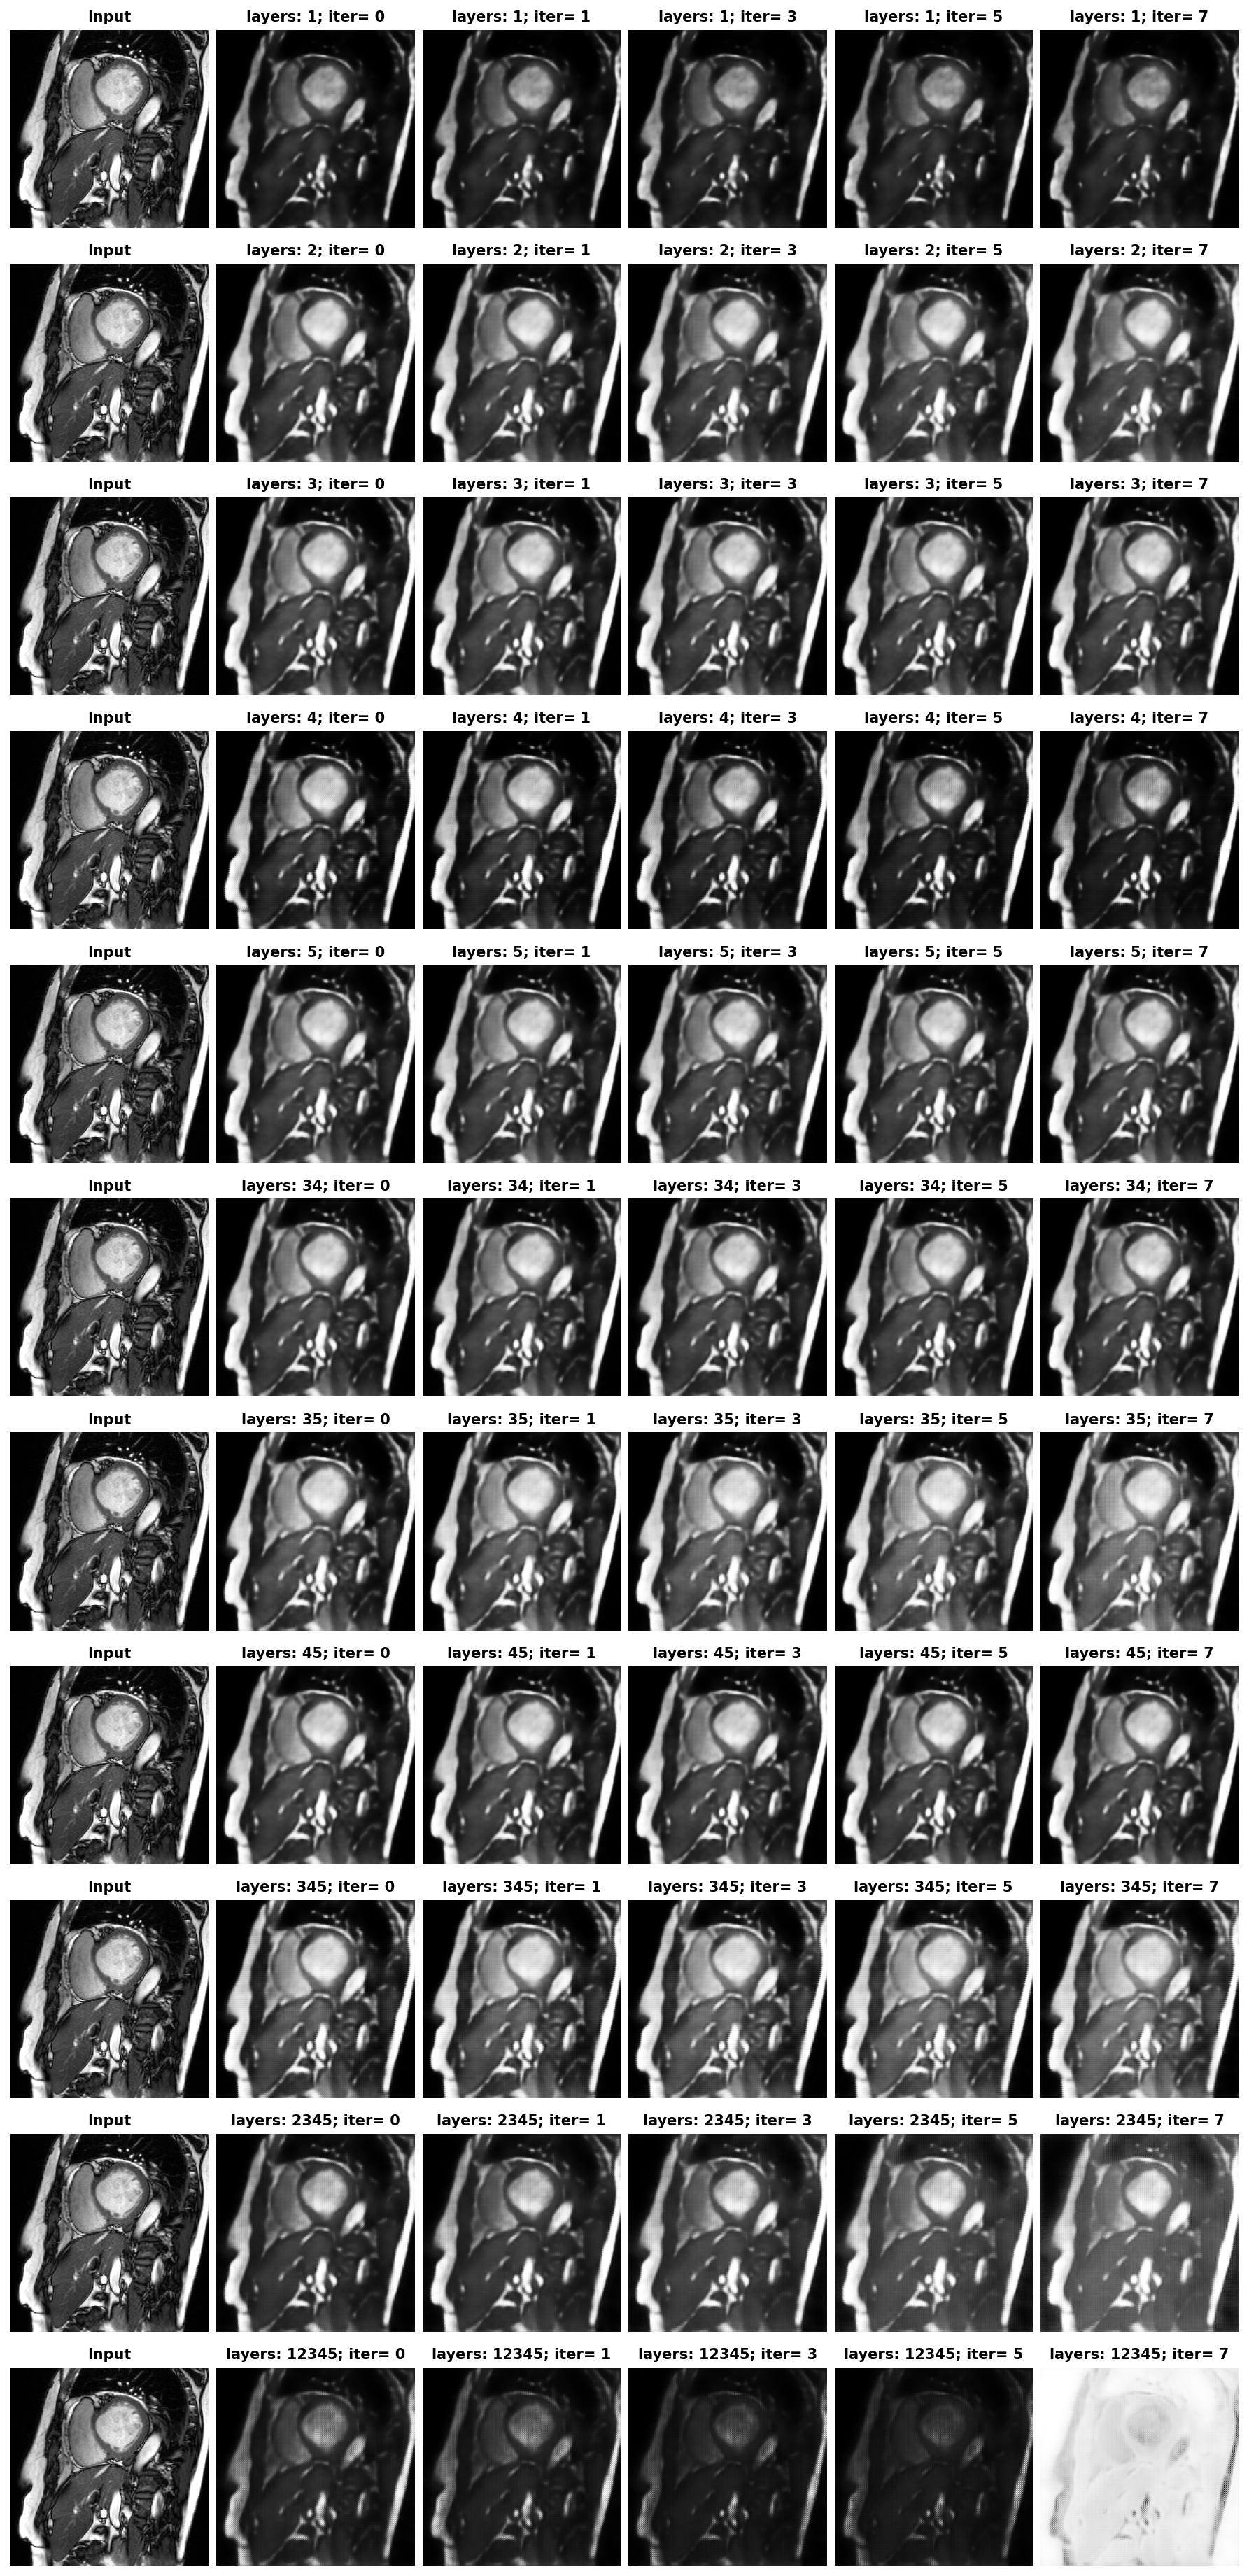

In [52]:
# visualization
fig,axes = plt.subplots(len(methods.values()),1+len(n_iter_list),figsize=(13,27), dpi=150)
font_size = 10
slice_id =3
i = 0
for (method,method_value) in methods.items():
    plot_image(image[slice_id],ax = axes[i,0], title = 'Input',font_size=font_size)
    for j,n_iter in enumerate(n_iter_list):
        result = results[method][n_iter]
        subtitle = f'layers: {method}; iter= {n_iter}'
        plot_image(result[0].detach().cpu().numpy()[slice_id,0],ax = axes[i,j+1], title =subtitle,font_size=font_size)
    i+=1
# plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1, wspace=0.04, hspace=0.1)

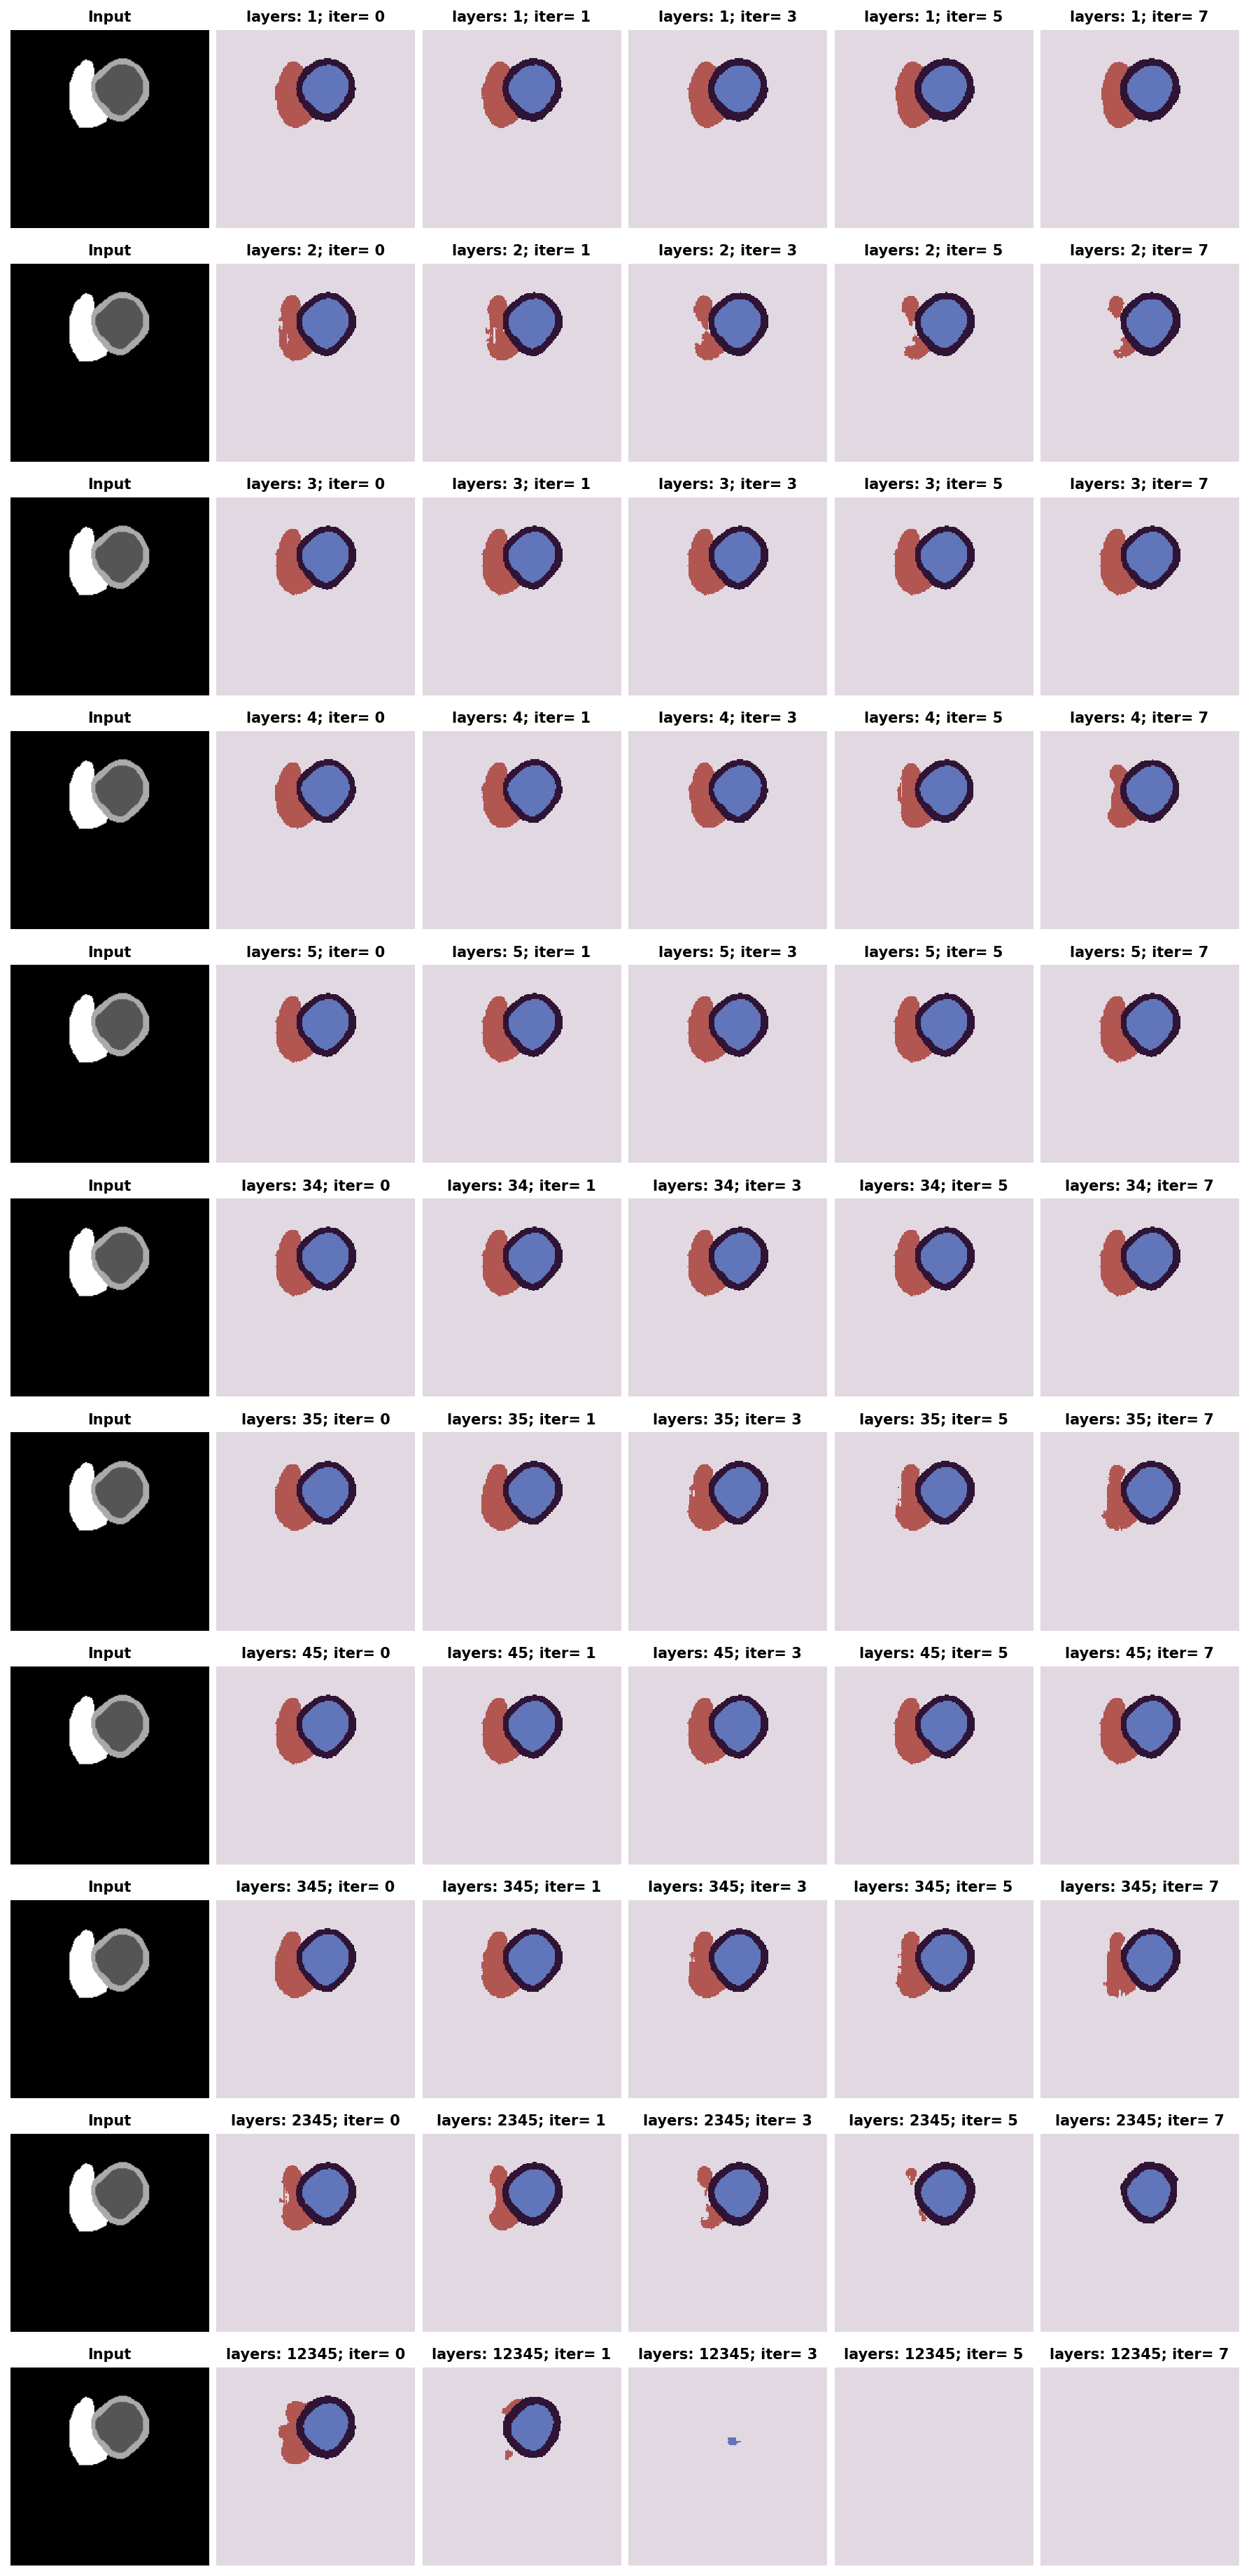

In [53]:
fig,axes = plt.subplots(len(methods.values()),1+len(n_iter_list),figsize=(13,27), dpi=150)

i=0
for (method,method_value) in methods.items():
    plot_image(label[slice_id],ax = axes[i,0], title = 'Input',font_size=font_size)
    for j,n_iter in enumerate(n_iter_list):
        result = results[method][n_iter]
        subtitle = f'layers: {method}; iter= {n_iter}'
        plot_general(result[1].max(1)[1].cpu().numpy()[slice_id],ax = axes[i,j+1], title =subtitle,font_size=font_size,cmap='twilight',vmin=0,vmax=num_classes)
    i+=1
# plt.tight_layout()
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=1, wspace=0.04, hspace=0.1)

In [54]:
torch.cuda.empty_cache()
